# How The Threat Landscape Changed in the Pandemic Year 

The purpose of this analysis is to analyze malicious domains submitted to url.abuse[.]ch for the year range of 2019 to 2020. The URL Haus project is an amazing resource used by security practicioners of all kinds to help share and provide insight into malicious urls discovered. The URLhaus project is created and managed by abuse[.]ch, a non profit security reasearcher that manages several additional projects to provide situational awareness and information to aid in internet security against malware.

**The goal of this analysis is to answer the following:**

- What type of malware is more prominant in the year of the pandemic vs the previous year
- Which tld is most seen this year related to malicious threats
- Based on analysis are there any specifc hunts or detections organizations can perform or put in place to identify traffic going to risky domains.


**Analysis Breakdown**
- Data Exploration 
- Data Cleaning
- Analysis 
- Reporting and Visualization

In [2]:
import pandas as pd
from csv import reader

#Data Exploration in prep for data cleaning. Converting items in list to quickly asses what the data looks like.


of = open("csv.txt")
rf = reader(of)
data = list(rf)

print(data[:10])


# Data preview of first 10 rows show some header data prior to columns. Will need to skip those rows prior to converting to pd dataframe and cleaning..


[['################################################################'], ['# abuse.ch URLhaus Database Dump (CSV)                         #'], ['# Last updated: 2020-12-29 15:44:07 (UTC)                      #'], ['#                                                              #'], ['# Terms Of Use: https://urlhaus.abuse.ch/api/                  #'], ['# For questions please contact urlhaus [at] abuse.ch           #'], ['################################################################'], ['#'], ['# id', 'dateadded', 'url', 'url_status', 'threat', 'tags', 'urlhaus_link', 'reporter'], ['944671', '2020-12-29 15:44:07', 'http://gbimkd.org/wp-includes/mzYzedwYUHNvfwTTy47Ey0o5tKUyazH0oXIs/', 'online', 'malware_download', 'doc,emotet,epoch2', 'https://urlhaus.abuse.ch/url/944671/', 'Cryptolaemus1']]


In [3]:
#Creating a dataframe , but will be skipping first 8 rows of header data as it is only information on the file.

urls = pd.read_csv("csv.txt",skiprows=8)

columns= urls.columns

print(urls.info(),"\n")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931755 entries, 0 to 931754
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   # id          931755 non-null  int64 
 1   dateadded     931755 non-null  object
 2   url           931755 non-null  object
 3   url_status    931755 non-null  object
 4   threat        931698 non-null  object
 5   tags          931755 non-null  object
 6   urlhaus_link  931755 non-null  object
 7   reporter      931755 non-null  object
dtypes: int64(1), object(7)
memory usage: 56.9+ MB
None 



## Data Exploration and Data Cleaning 

- Dataframe created successfully, identifying over 900,000 entries. 
- Datacleaning steps:
 1. Clean up columns to make them easier to work with
 2. Create a new column for year based on dateadded column
 3. Create a new column for month based on date added column
 4. Identify null values
 5. Create a new column for the top level domain bsed or url
 
- Below's output will show you the original columns, vs the new columns following some alterations to aid in consistency such as changing to snake case.

- Also shown below is a preview of the data.
 

In [5]:
#loop through column headers to make naming convention more consistent

columns = urls.columns

print("old columns","\n", columns,"\n")

new_columns = []

for c in columns:
    new = c
    if c == "# id":
        new = "id"
        new_columns.append(new)
    elif c =="dateadded":
        new = "date_added"
        new_columns.append(new)
        
    else:
        new_columns.append(new)
        
urls.columns = new_columns


        
print("new columns", "\n",urls.columns,"\n")


print("data preview: \n",urls.head(2))


old columns 
 Index(['# id', 'dateadded', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter'],
      dtype='object') 

new columns 
 Index(['id', 'date_added', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter'],
      dtype='object') 

data preview: 
        id           date_added  \
0  944671  2020-12-29 15:44:07   
1  944670  2020-12-29 15:44:05   

                                                 url url_status  \
0  http://gbimkd.org/wp-includes/mzYzedwYUHNvfwTT...     online   
1                       http://116.124.219.2:55737/i     online   

             threat               tags                          urlhaus_link  \
0  malware_download  doc,emotet,epoch2  https://urlhaus.abuse.ch/url/944671/   
1  malware_download     32-bit,arm,elf  https://urlhaus.abuse.ch/url/944670/   

        reporter  
0  Cryptolaemus1  
1       geenensp  


## Data Parsing - date_added Field

- Below I have parsed the date_added column, by extracting and creating seperate columns for just the year and month. This will aid in analysis and filtering as data I will be focusing on in this analysis is data from the years of 2019 and 2020.
- After importing the datetime library, I've converted the date_added field to the dtype of date.
- Also you can see there's a total of 931,755 entries total in dataset. This number will decrease once filtering of the year's occur.



In [6]:
import datetime 

#converting date_added field to a date dtype,and creating and adding seperate columns to display month and year.

urls["date_added"] = pd.to_datetime(urls["date_added"])

urls["year"] = urls["date_added"].dt.year
urls["month"] = urls["date_added"].dt.strftime("%b")

In [369]:
print("Description of Month's data:\n",urls["month"].describe(),"\n")

print("Description of Year's data:\n",urls["year"].describe())


Description of Month's data:
 count     931755
unique        12
top          Sep
freq      202906
Name: month, dtype: object 

Description of Year's data:
 count    931755.000000
mean       2019.608268
std           0.663945
min        2018.000000
25%        2019.000000
50%        2020.000000
75%        2020.000000
max        2020.000000
Name: year, dtype: float64


## Data Parsing- URL Column 

The next field I want to parse to be able to obtain some valuable insight for analysis is the URL column. When someone submits a URL to URLHause, they include the URL(website) being used to deliver malware. A URL however can contain a lot of information such as the protocol | domain| top level domain|path|port. The two pieces of information I would like to extract for analysis would be the domain and top level domain. 


- I will use the following workflow process to assess how I can extract this information:

 1. Explore the data in the column
 2. Identify patterns and special cases
 3. Remove non applicable characters
 4. Perform any data type conversions necessary
 5. Rename column or create new column if required.
 
What I identified:
- Data contained in a URL can be either a IP address or a domain that was resolved by dns.
- Some URL's also contained port numbers.

I've previewed the strings below and split them based on the forward slash delimeter as that is is a consisten pattern seen in all url request. i.e. http[s]://[hostname/ip]/[path] or http[s]://[hostname/ip]:[port/path]

Goal:

I will create a new column named TLD that will contain where:
 1. For rows where the URL is an IP address, because I'm not so concerned with what the IP is but rather that it is an IP rather than a resolved host name.  I will indicate "IP" as the tld.
 2. Fore rows where the URL is not an IP, I will extract only the tld and append that value in that column (i.e. .com, .ru,.net).
 

Pattern Identification:
- As mentioned above, all request follow similar patterns, so i initially identified the "/" as a good starting deliminer to break up my URL's.



In [8]:
print(urls["url"].str.split("/").head(30))

0     [http:, , gbimkd.org, wp-includes, mzYzedwYUHN...
1                     [http:, , 116.124.219.2:55737, i]
2     [http:, , www.ticketshd.com, wp-content, FUfYN...
3     [http:, , thefiercevagabond.com, cgi-bin, Ebob...
4     [http:, , 175.10.51.6:57578, Mozi.a;chmod+777+...
5     [https:, , www.hintup.com.br, wp-content, FE9Q...
6     [http:, , ondigital.one, wp-admin, up9pp9KLyef...
7     [https:, , hdgarden.vn, wp-includes, aZBWciJOr...
8                     [http:, , 115.56.159.28:57022, i]
9     [https:, , www.lixko.com, wp-includes, LEq9VJd, ]
10    [https:, , surfboarddigital.com, carol-stream-...
11             [https:, , srishtiherbs.com, jms, bq8, ]
12         [https:, , unikaryapools.com, wp, ysFiRq1, ]
13                  [http:, , 207.254.247.210:49250, i]
14                   [http:, , 120.57.103.125:55379, i]
15        [https:, , technicalashish.in, wp-admin, M, ]
16    [http:, , thespaceastronauts.com, wp-content, ...
17        [http:, , sanghuangvip.com, wp-admin, 

Based on the preview of data above, the hostname(that includes tld)/ip is located at index 2. Therefore, I will extract the domain/ip and place in a newly created column named host as a place holder.

In [9]:
urls["host"]= urls["url"].str.split("/").str[2]

print(urls["host"].head(10))

0               gbimkd.org
1      116.124.219.2:55737
2        www.ticketshd.com
3    thefiercevagabond.com
4        175.10.51.6:57578
5        www.hintup.com.br
6            ondigital.one
7              hdgarden.vn
8      115.56.159.28:57022
9            www.lixko.com
Name: host, dtype: object


Now that I have the host/tld/IP extracted, I will do some additional parsing to isolate the TLD.

In the following section I will create an addition new column named tld. To accomplish this, I will need to do the following:
- Perform another split on the coloumn, but this split will be based on the "." dellimeter.
- I will append the last item in the index to the tld column

- Some challenges with the data and observations are
 1. some domains have two tld appended i.e. .org.com
 2. request to IP addresses also include port value.
 
- To help with this, I will create a test dataframe with a subset of data. For fields that contain":", I will indicate that as an IP, for all others, I will simply take the last item in the index listed.

**Update:**  An error was detected in the parsing of host that were IP addresses. Regex was used instead to look for a value in the final index. (This fix occured 2/2/21)


In [194]:
testdata= urls[["year","host"]].head(10000)

#print(testdata)

testdata["tld"] = testdata["host"].str.split(".").str[-1]

print(testdata)

#if value in last index contains a digit, I will assume it is an ip address 
filter = testdata["tld"].str.contains('\d+')



testdata.loc[filter,"tld"] = "ip"

print(testdata.info())

print(testdata)






      year                   host        tld
0     2020             gbimkd.org        org
1     2020    116.124.219.2:55737    2:55737
2     2020      www.ticketshd.com        com
3     2020  thefiercevagabond.com        com
4     2020      175.10.51.6:57578    6:57578
...    ...                    ...        ...
9995  2020   36.248.227.203:46113  203:46113
9996  2020    59.97.175.150:49961  150:49961
9997  2020    182.120.38.12:50340   12:50340
9998  2020  182.122.168.223:33773  223:33773
9999  2020   119.166.160.254:6486   254:6486

[10000 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    10000 non-null  int64 
 1   host    10000 non-null  object
 2   tld     10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB
None
      year                   host  tld
0     2020             gbimkd.org  org
1     2020  

Now that I've tested the code, and confirmed that the parsing works on a subset of data. I will apply parsing to the full dataset and previiew the data below.



In [195]:
urls["tld"] = urls["host"].str.split(".").str[-1]

filter = urls["tld"].str.contains('\d+')

urls.loc[filter,"tld"] = "ip"

print(urls[["year","host","tld"]].head(20))

    year                    host  tld
0   2020              gbimkd.org  org
1   2020     116.124.219.2:55737   ip
2   2020       www.ticketshd.com  com
3   2020   thefiercevagabond.com  com
4   2020       175.10.51.6:57578   ip
5   2020       www.hintup.com.br   br
6   2020           ondigital.one  one
7   2020             hdgarden.vn   vn
8   2020     115.56.159.28:57022   ip
9   2020           www.lixko.com  com
10  2020    surfboarddigital.com  com
11  2020        srishtiherbs.com  com
12  2020       unikaryapools.com  com
13  2020   207.254.247.210:49250   ip
14  2020    120.57.103.125:55379   ip
15  2020      technicalashish.in   in
16  2020  thespaceastronauts.com  com
17  2020        sanghuangvip.com  com
18  2020     117.242.211.7:40745   ip
19  2020  nasabatam.bbtbatam.com  com


## Final Data Cleaning and Parsing Efforts

Some additional steps I want to take prior to analysis include:

- Evaluate null values
    1. There isn't a lot of null values within the dataset. Most null values look to be in the threat column which will not tbe used for analysis. 

- Evaluate tags columns
    1. My initial thought would be to create a new table by year just containing the tags and their months
    2. I will use the split method to look for a "," than add the tag to the new table.

- Final Assessment:
     - I've created seperate dataframes for each year with it's tags

     - I parsed through the tags column to create a frequency table for each year
 
     - I will then convert each frequency tables to a dataframe(for their year) to aid in sorting. Below you will see how the frequency table looks for 2019. Because of the size, I am not showing the frequency table of 2020.

In [196]:

print(urls.columns)

print(urls.info())


Index(['id', 'date_added', 'url', 'url_status', 'threat', 'tags',
       'urlhaus_link', 'reporter', 'year', 'month', 'host', 'tld'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 931755 entries, 0 to 931754
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            931755 non-null  int64         
 1   date_added    931755 non-null  datetime64[ns]
 2   url           931755 non-null  object        
 3   url_status    931755 non-null  object        
 4   threat        931698 non-null  object        
 5   tags          931755 non-null  object        
 6   urlhaus_link  931755 non-null  object        
 7   reporter      931755 non-null  object        
 8   year          931755 non-null  int64         
 9   month         931755 non-null  object        
 10  host          931755 non-null  object        
 11  tld           931755 non-null  object        
dtypes: datetime64[

In [197]:
#2019 Creating a mask to allow me to filter data by year
y19_bool = urls["year"] == 2019
y20_bool = urls["year"] == 2020

#This will filter using boolean mask created to only values of 2019 
t_19 = urls[y19_bool]

# This creates a series of only tag values for 2019
tags_19 = t_19["tags"]

# Empty dict, to house tags. 
tag_freq_19 = {}

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_19:
    split = t.split(",")
    for s in split:
        if s not in tag_freq_19:
            tag_freq_19[s] = 1
        else:
            tag_freq_19[s] += 1
            
print(tag_freq_19)




{'AgentTesla': 1749, 'exe': 52620, 'None': 8980, 'elf': 60786, 'bashlite': 13963, 'gafgyt': 16350, 'zip': 8869, 'mirai': 32173, 'HawkEye': 516, 'iso': 24, 'Loki': 1081, 'img': 3, 'KPOTStealer': 46, 'AZORult': 1015, 'Trickbot': 1344, 'emotet': 45737, 'heodo': 41401, 'PredatorStealer': 427, 'CAN': 1220, 'Nemty': 4, 'Ransomware': 1876, 'downloader': 149, 'orcus': 8, 'CoinMiner': 175, 'doc': 25379, 'predator': 15, 'SystemBC': 29, 'Raccoon Stealer': 1, 'ServHelper': 24, 'Amadey': 25, 'CobaltStrike': 123, 'powershell': 48, 'geofenced': 3706, 'qbot': 174, 'Quakbot': 178, 'USA': 2170, 'vbs': 6327, 'IcedID': 540, 'BrushaLoader': 1214, 'POR': 2, 'vbs-in-zip': 1, 'Gozi': 5677, 'password': 1957, 'CZE': 28, 'ursnif': 912, 'QuasarRAT': 83, 'rat': 696, 'MetaMorfo': 28, 'CHL': 6, 'redirect': 276, 'opendir': 430, 'RTF': 316, 'NanoCore': 799, 'NetWire': 324, 'Hermes': 1, 'Task': 126, 'RaccoonStealer': 52, 'JPN': 39, 'JP': 1, 'Tinba': 134, 'ArkeiStealer': 206, 'RevengeRAT': 25, 'njRAT': 169, 'TrickbotLoa

In [14]:
'''This code block will create the frequency table for 2020 tags. No preview is shown because of size.'''

#This will filter using boolean mask created to only values of 2020
t_20 = urls[y20_bool]

# This creates a series of only tag values for 2020
tags_20 = t_20["tags"]

# Empty dict, to house tags. 
tag_freq_20 = {}

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_20:
    split = t.split(",")
    for s in split:
        if s not in tag_freq_20:
            tag_freq_20[s] = 1
        else:
            tag_freq_20[s] += 1
            



## New Tables for Unique Tags and Counts by Year
Now that frequency tables for the unique tags of 2019 and 2020 have been created, I will now transform them from a dictionary into their own respective dataframes(tables) that include the unique tag, and the count of how many times that tag was observed.

New tables

tag19 - 2019 unique tags observed and their counts.
tag20 - 2020 unique tags observed and their counts.

In [15]:
#New Dataframe of 2019 Tags
tag19 = pd.Series(tag_freq_19).to_frame().reset_index()

tag19.columns = ["tag","count"]

print(tag19)


#New Dataframe of 2020 Tags

tag20 = pd.Series(tag_freq_20).to_frame().reset_index()

tag20.columns = ["tag","count"]

print(tag20)

                  tag  count
0          AgentTesla   1749
1                 exe  52620
2                None   8980
3                 elf  60786
4            bashlite  13963
..                ...    ...
749             jeefo      1
750             Xpert      1
751   passwordstealer      1
752   passwordstealer      1
753               NDL      1

[754 rows x 2 columns]
           tag  count
0          doc  27521
1       emotet  32796
2       epoch2  15629
3       32-bit  92972
4          arm  13014
..         ...    ...
800    #gafgyt      1
801  lunlayloo      1
802       html      1
803        CZE      1
804   DigiCert      2

[805 rows x 2 columns]


## Breakdown of Submissions by Month

After successfully parsing the tags by year, I wanted to potentially analyze the number of submissions by month for each year. To accomplish this, I used the template I used above to filter by year.

- I created a dataframe that contained tags and the month they were submitted.
- I also created an empty dataframe with columns of tag and month.
 - I iterated through the table that contained the tags and their corresponding month
 - For each row, I segmented the tag field and month field into their own variables
 - For each tag field, I used the split fuction to parse it based on the "," delimeter.
 - I created a new dictionary entry to append the tag and it's coressponding month
 
 Tables Created:
 
 1. tags_table_19 - This is a list of every instance of a tag and the month it was submitted in 2019.
 2. months_19 - This is a breakdown of tag submitted by month for 2019.
 3. tags_table_20 - This is a list of every instance of a tag and the month it was submitted in 2020.
 4. months_20 - This is a breakdown of tag submitted by month for 2020.

In [16]:
#2019 Creating a mask to allow me to filter data by year
y19_bool = urls["year"] == 2019


#This will filter using boolean mask created to only values of 2019 
t_19 = urls[y19_bool]


# This creates a series of only tag values for 2019
tags_19 = t_19[["tags","month"]]

print(tags_19["month"].value_counts())

tags_table_19 = pd.DataFrame(columns = ['tag', 'month']) 


#print(tags_19)
#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_19.iterrows():
    tag = t[1][0]
    month = t[1][1]
    
    #print(tag)
    #print(month)
    split = tag.split(",")
    for s in split:
            new_row = {"tag":s,"month":month}
            tags_table_19 = tags_table_19.append(new_row,ignore_index=True)
            
            
        
          
            


#print(tags_table_19)
months_19 = tags_table_19["month"].value_counts()

print(months_19)





Feb    33842
Mar    19572
Dec    18918
Apr    18716
May    16762
Jan    13694
Oct    13343
Nov    10826
Jul     8180
Sep     7898
Jun     7607
Aug     6918
Name: month, dtype: int64


KeyboardInterrupt: 

In [364]:
#2020 Creating a mask to allow me to filter data by year
y20_bool = urls["year"] == 2020


#This will filter using boolean mask created to only values of 2020
t_20 = urls[y20_bool]

# This creates a series of only tag values for 2020
tags_20 = t_20[["tags","month"]]



tags_table_20 = pd.DataFrame(columns = ['tag', 'month']) 

#Because tags are in a list of a list, will need to loop through and parse list before adding to dictionary
for t in tags_20.iterrows():
    tag = t[1][0]
    month = t[1][1]
    
    
    split = tag.split(",")
    for s in split:
            new_row = {"tag":s,"month":month}
            tags_table_20 = tags_table_20.append(new_row,ignore_index=True)

months_20 =tags_table_20["month"].value_counts()
print(months_20)

Sep    419629
Oct    310399
Nov    205218
Dec    161310
Jun     74278
Aug     71977
Jan     62393
Apr     45837
Jul     38698
May     36097
Feb     34047
Mar     23758
Name: month, dtype: int64


# Final Analysis on How The Threat Landscape Changed in the Pandemic Year 


If you made it to this part, I'm glad you're still with me! If you've skipped the sections pertaining to the data exploration and cleaning efforts here's a summary of what was done:

1. The URL Haus dataset was obtained on Dec, 29, 2020. The original dataset that I imported had 8 columns originally, with close to 1 million entries. Here's a listing of the original columns:

        ['# id', 'dateadded', 'url', 'url_status', 'threat', 'tags','urlhaus_link', 'reporter'],
 
2. Data Cleaning summary:
     - I cleaned up the column headers to make naming convention more consistent.
     - I converted date_added column data to the date data type,and created seperate columns to display month and year.
     - I created additional columns titled "host" and "tld". The host column would contain the full url, and the tld column would contain the tld (i.e. .com,.org) from the parsed the host field.
     - If the url was an IP address, I simply placed "IP" in "tld" column. 
 
     - Tags column:
         - Each entry often had multiple tags, which essentially caused a list within a list.
         - In order to get full use and valuable information from this column, I initially created a new table with all tags and its coresponding month. For this technique I used the split method to look for a "," for each tag to add it's unique tag to the table.
         - I decided to go one step further and create a table for each year that contained each tags in a seperate line with its corresponding month it was submitted.
     
3. Final data used in analysis:
    Below is a listing of the final tables I created that was derived from the master dataset titled "urls". A list of each table's columns and a table descriptions can be seen below:
    
    - urls
 
      1. Description: Full dataset after exploration and cleaning
      2. columns: 'id', 'date_added', 'url', 'url_status', 'threat', 'tags','urlhaus_link', 'reporter', 'year', 'month', 'host', 'tld
     
    - tag19
      1. Description:
      2. Columns:
      
    - tags_19:
      1. Description:
      2. Columns:
    - total_by_month:
      1. Description:
      2. Columns:
    - tag20
      1. Description:
      2. Columns:
      
    - tags_table_19
      1. Description:
      2. Columns:'tag', 'month'
      
    - tags_table_20
      1. Description:
      2. Columns:'tag', 'month'
    
3. Analysis Questions:

    - What type of malware is more prominant in the year of the pandemic vs the previous year?
    - Which tld trends are identified in the year of the pandemic vs the previous year?
    - Based on the tags provided, which file types were predominately used to deliver malware?


 
 


### The Year of 2019 in Review

Tags are used with submissions to URL Hause to provide insight into the type of submission. These tags can range from the malicious file type hosted on the domain to the malware family the payload belongs to. Because of the variety, I created a file list to exclude file type to focus primarily on malware families. This list is not an all inclusive list. However, it does count for some of the top file types.



Based on my analysis Emotet , heodo and mirai rounded out the top 3 submitted entries to URLHaus in 2019. Accounting for approximately 48% of all unique tags submitted in 2019.I don't think there's much surprise that Emotet took the top spot in 2019. The well known banking trojan was a huge disrupter in the cyber security space until very recently.Known to primarily spread through email, according to eSentire a Canadian based managed defense and response company, Emotet accounted for 20% of all malware related incidents in that year.

When we review number 2 on the list, Heodo a very near distant cousin to Emotet. It holds very similar characteristics to Emotet, especially with it's primary delivery method through email. 

Number 3 on the list is Mirari, Japanese orgin malware that operates as a botnet. According to cloudflare, Mirari targets heavily on IoT devices such as routers, and home cameras.

**Total Submissions By Month**
I was currious what month in 2019 had the most submissions by tag. Surprisengly February



              tag  count
15         emotet  45737
16          heodo  41401
7           mirai  32173
261       payload  18353
80         epoch2  18099
5          gafgyt  16350
81         epoch1  15454
4        bashlite  13963
41           Gozi   5677
94       Troldesh   5053
78         hajime   4987
32      geofenced   3706
84       Dreambot   3464
76       Formbook   3092
82         epoch3   2765
35            USA   2170
42       password   1957
20     Ransomware   1876
0      AgentTesla   1749
299        stage2   1568
265           RUS   1351
14       Trickbot   1344
18            CAN   1220
38   BrushaLoader   1214
343         miner   1195 

Percentage of top 3 of total:  0.49

Total Submissions by Month 
 Feb    33842
Mar    19572
Dec    18918
Apr    18716
May    16762
Jan    13694
Oct    13343
Nov    10826
Jul     8180
Sep     7898
Jun     7607
Aug     6918
Name: month, dtype: int64


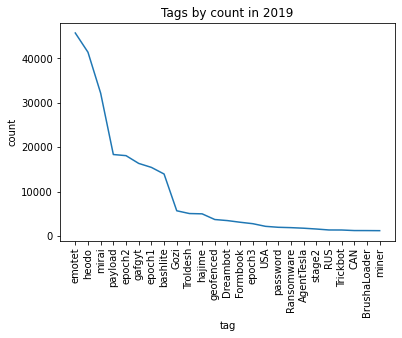

In [353]:
import matplotlib.pyplot as plt

file_list = ["exe","None","doc","zip","xls","vbs","elf","js"]

#Top 25,non file extension tags of 2019 

minus = ~(tag19["tag"].isin(file_list))
top_tags_2019 = tag19[minus].sort_values(by="count",ascending=False).head(25)


# Line chart of top 25, non file extension tags of 2019
plt.plot(top_tags_2019["tag"],top_tags_2019["count"])
plt.xticks(rotation=90)
plt.xlabel("tag")
plt.ylabel("count")
plt.title("Tags by count in 2019")

#percentage of top 3 items of total data.
print(top_tags_2019,"\n")
print("Percentage of top 3 of total: ",(top_tags_2019["count"].head(3).sum()/top_tags_2019["count"].sum()).round(2))




#Total submissions by month in 2019
mask_19 = urls["year"] == 2019
months = urls[["month","year"]]
months = months[mask_19]

total_by_month = months["month"].value_counts()



print("\nTotal Submissions by Month \n",total_by_month)




### Explanation for domain analysis for 2019

AxesSubplot(0.125,0.125;0.775x0.755)

Top Domains Used to Distribute Heodo:

 Domain Count 
 com    18189
ip      1910
org     1497
net     1363
ru      1290
br      1288
vn      1040
in       814
nl       715
ir       644
Name: tld, dtype: int64

Top Domains Used to Distribute Emotet:

 Domain Count 
 com    20160
ip      1966
org     1617
net     1517
br      1428
ru      1351
vn      1143
in       911
nl       756
ir       681
Name: tld, dtype: int64

Top Domains Used to Distribute Mirari:

 Domain Count 
 ip      31850
org        42
com        29
xyz        29
ml         24
cf         21
tk         21
biz        20
net        17
club       17
Name: tld, dtype: int64


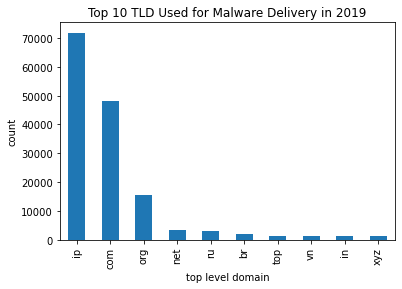

In [356]:
nt = urls[['tags','month','year','tld','url']]
mask = nt['year']==2019

nt= nt[mask]

# Top domains used to deliver malware

tld = urls["tld"]
tld = tld[mask_19]


# Bar chart of top 10, tld used to deliver malware in 2019
top = tld.value_counts().head(10).plot(kind = 'bar',stacked=True)

plt.xlabel("top level domain")
plt.ylabel("count")
plt.title("Top 10 TLD Used for Malware Delivery in 2019")

print(top)

# identifying the top domains for the top 3 submissions, and some random popular malware families
mal_list = ['emotet','Emotet','heodo','mirai','AgentTesla','Gozi','Trickbot']
pattern = '|'.join(mal_list)

m = nt["tags"].str.contains(pattern)


#print(nt[m])


table_malware = nt[m]

heodo = table_malware["tags"].str.contains( "heodo")
emotet = (table_malware["tags"].str.contains( "emotet")) | (table_malware['tags'].str.contains('Emotet'))
mirai = table_malware["tags"].str.contains( "mirai")

#Tables of the top domains used to distribute malware from the top 3 submissions for malware in 2019.
print("\nTop Domains Used to Distribute Heodo:\n\n","Domain","Count","\n",table_malware.loc[heodo,'tld'].value_counts().head(10))
print("\nTop Domains Used to Distribute Emotet:\n\n","Domain","Count","\n",table_malware.loc[emotet,'tld'].value_counts().head(10))
print("\nTop Domains Used to Distribute Mirari:\n\n","Domain","Count","\n",table_malware.loc[mirai,'tld'].value_counts().head(10))







### Explanation of some other popular 

In [362]:
at = table_malware["tags"].str.contains( "AgentTesla")
gozi = table_malware["tags"].str.contains( "Gozi")
tb = table_malware["tags"].str.contains("Trickbot")

#Tables of some additional domains used to deliver some popular malware in 2019.
print("\nTop Domains Used to Distribute Agent Tesla:\n\n","Domain","Count","\n",table_malware.loc[at,'tld'].value_counts().head(10))
print("\nTop Domains Used to Distribute Gozi:\n\n","Domain","Count","\n",table_malware.loc[gozi,'tld'].value_counts().head(10))
print("\nTop Domains Used to Distribute Trickbot:\n\n","Domain","Count","\n",table_malware.loc[tb,'tld'].value_counts().head(10))



Top Domains Used to Distribute Agent Tesla:

 Domain Count 
 com    525
ip     282
org     99
top     80
pt      68
vn      45
uk      44
net     43
br      40
eu      39
Name: tld, dtype: int64

Top Domains Used to Distribute Gozi:

 Domain Count 
 com        4795
top         143
xyz         103
info         98
club         88
email        80
ip           57
company      55
band         52
net          45
Name: tld, dtype: int64

Top Domains Used to Distribute Trickbot:

 Domain Count 
 ip     568
com    473
top     52
org     35
net     24
uk      18
fr      14
xyz     14
ca      13
br      11
Name: tld, dtype: int64


### The Year of 2020 in Review


Mozi https://blog.lumen.com/new-mozi-malware-family-quietly-amasses-iot-bots/



          tag   count
10       Mozi  384226
3      32-bit   92972
7        mips   79660
1      emotet   32796
6       heodo   31264
74     Qakbot   17084
34   Trickbot   16662
2      epoch2   15629
15    opendir   15060
56    Quakbot   14942
13     gafgyt   13217
35      mirai   13123
4         arm   13014
8      epoch1   10578
25   bashlite   10255
52       Gozi    8459
91    ZLoader    7097
22   GuLoader    6383
20     epoch3    6324
21  encrypted    6062


NameError: name 'top_tags_2020' is not defined

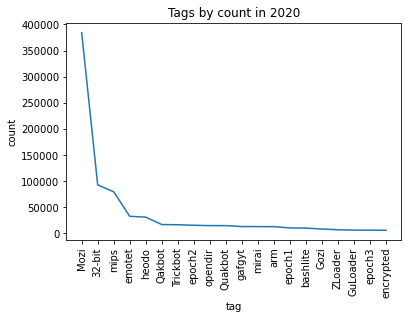

In [374]:
file_mask = ~(tag20["tag"].isin(file_list))

tag_20_final = tag20[file_mask].sort_values(by=["count"],ascending=False).head(20)

plt.plot(tag_20_final["tag"],tag_20_final["count"])

plt.xticks(rotation=90)

plt.xlabel("tag")
plt.ylabel("count")
plt.title("Tags by count in 2020")

print(tag20[file_mask].sort_values(by=["count"],ascending=False).head(20))

#percentage of top 3 items of total data.
print(top_tags_2020,"\n")
print("Percentage of top 3 of total: ",(top_tags_2020["count"].head(3).sum()/top_tags_2020["count"].sum()).round(2))


#Total submissions by month in 2020
mask_20 = urls["year"] == 2020
months = urls[["month","year"]]
months = months[mask_20]

total_by_month = months["month"].value_counts()



print("\nTotal Submissions by Month \n",total_by_month)


Submissions by month

Huge uptick identified in June 2020 vs June 2019

In [56]:
mask = urls["year"] == 2019

sample = urls[["tags","month"]]

counts_19 = sample[mask].value_counts("month")

mask_20 = urls["year"] == 2020

counts_20 = sample[mask_20].value_counts("month")

print(counts_19,"\n","\n",counts_20)


print(months_19)



month
Feb    33842
Mar    19572
Dec    18918
Apr    18716
May    16762
Jan    13694
Oct    13343
Nov    10826
Jul     8180
Sep     7898
Jun     7607
Aug     6918
dtype: int64 
 
 month
Sep    183186
Oct    142419
Nov     97638
Dec     72160
Jun     32890
Aug     25570
Jan     22716
Apr     22079
May     17758
Jul     16443
Feb     15640
Mar     12619
dtype: int64


NameError: name 'months_19' is not defined

In [69]:
yr_mask = urls["year"] == 2019
year_total = urls[yr_mask]

print(year_total.describe())

yr_mask = urls["year"] == 2020
year_total = urls[yr_mask]

print(year_total["month"].value_counts())

                  id      year
count  176276.000000  176276.0
mean   190793.475266    2019.0
std     52033.128091       0.0
min    100773.000000    2019.0
25%    145709.750000    2019.0
50%    190635.500000    2019.0
75%    235580.250000    2019.0
max    281624.000000    2019.0
Sep    183186
Oct    142419
Nov     97638
Dec     72160
Jun     32890
Aug     25570
Jan     22716
Apr     22079
May     17758
Jul     16443
Feb     15640
Mar     12619
Name: month, dtype: int64


In [365]:
#Exporting CSV's

print(top_tags_2019["count"].head(3).sum())
print(top_tags_2019["count"].sum())


print("Exporting table malware heodo\n")
table_malware_heodo= table_malware.loc[heodo,'tld'].value_counts().head(10)

print("\nExporting table malware Emotet:\n")
table_malware_emotet = table_malware.loc[emotet,'tld'].value_counts().head(10)

print("\nExporting table malware Mirari:\n")
table_malware_mirari = table_malware.loc[mirai,'tld'].value_counts().head(10)

print("Exporting table malware Agent Tesla:\n")
table_malware_at = table_malware.loc[at,'tld'].value_counts().head(10)

print("Exporting table malware Gozi:\n\n","Domain","Count","\n")
table_malware_gozi = table_malware.loc[gozi,'tld'].value_counts().head(10)

print("Exporting table malware Trickbot:\n\n","Domain","Count","\n")
#table_malware_tb= table_malware.loc[tb,'tld'].value_counts().head(10)

#topdomains = tld.value_counts().head(10)


# top_tags_2019.to_csv('top_tags_2019.csv')
# total_by_month.to_csv('total_by_month_2019.csv')
# table_malware_heodo.to_csv('topheododomains.csv')
# table_malware_emotet.to_csv('topemotetdomains.csv')
# table_malware_mirari.to_csv('topmiraridomains.csv')
# topdomains.to_csv('top2019domains.csv')
# table_malware_at.to_csv('agenttesladomains.csv')
# table_malware_gozi.to_csv('gozidomains.csv')
# months_20.to_csv('months2020breakdown.csv')


119311
245918

Top Domains Used to Distribute Heodo:

 Domain Count 


Top Domains Used to Distribute Heodo:

 Domain Count 


Top Domains Used to Distribute Emotet:

 Domain Count 


Top Domains Used to Distribute Mirari:

 Domain Count 


Top Domains Used to Distribute Agent Tesla:

 Domain Count 


Top Domains Used to Distribute Gozi:

 Domain Count 


Top Domains Used to Distribute Trickbot:

 Domain Count 

